In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

Load $Y_{bus}$ matrix from MATLAB

In [2]:
# Note: in per-unit
Y = loadmat('Ybus')['Ybus'].todense()

Problem parameters, modeled after the network in Example 11_9 in PowerWorld Simulator 18 (Glover, Sarma & Overbye Edition) [Fourth Edition Sample Cases](https://www.powerworld.com/simulator-18-glover-sarma-overbye-edition-download)

In [3]:
# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# System base, in MVA
base = 100

# The load consumed at each bus
p_d = np.array([40, 150, 80, 130])/base

# Matrix defining the cost of the generators
# The i, j element is the coefficient of the power produced at the ith generator raised to the j-1 power
# Copied from PowerWorld
C = np.array(
    [
        [373.5, 10, 0.016],
        [403.6, 8, 0.018],
        [253.2, 12, 0.018]
    ]
)

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.array(
    [
        [0, 150, 150, 0, 0],
        [0, 0, 120, 100, 200],
        [0, 0, 0, 222, 0],
        [0, 0, 0, 0, 60],
        [0, 0, 0, 0, 0]
    ]
)
P_line = (P_line+P_line.T)/base

# Minimum and maximum generator outputs, taken from PowerWorld
p_min = np.array([100, 150, 0])/base
p_max = np.array([400, 500, 300])/base

# The buses with generators and loads
G = np.array([1, 2, 4])-1
L = np.array([2, 3, 4, 5])-1

# Transformation matrices. These define the change-of-variables from the generator/load spaces to the bus space.
AG = np.zeros((N,len(G)))
AG[G,:] = np.eye(len(G))
AL = np.zeros((N,len(L)))
AL[L,:] = np.eye(len(L))

First, we solve conventional supply-side OPF. Confirm that the total cost is consistent with PowerWorld.

In [4]:
# Real power produced by each generator
p_g = cp.Variable(len(G))

# Voltage angle at each bus
delta = cp.Variable(N)

# Set constraints (generator min/max, DC power flow, line MVA limits)
constraints = [
    p_g >= p_min,
    p_g <= p_max,
    AG@p_g-AL@p_d == -B@delta,
    cp.multiply(B, delta[:,np.newaxis]-delta[np.newaxis,:]) <= P_line
]

# Solve DC OPF
cp.Problem(
    cp.Minimize(cp.vec(C.T)@cp.vec(cp.vstack([(base*p_g)**n for n in range(3)]))),
    constraints
).solve(max_iter=30000)

5840.788888888889

In [5]:
# Check that matches PowerWorld's total hourly cost for Example 11_9 when solved with DC OPF
assert(round(_,1)==5840.8)

Now let's solve a **demand-side** problem with zero marginal cost, fixed supply, and elastic demand. For this minimal example, we make the follwing assumptions:
- Each load submits a demand curve. The system operator dispatches to maximize total utlity $U(P)$.
- For each load, elasticity is constant. That is, the marginal utility for load $i$ is given by $\frac{dU_i}{dP_i}=K_iP_i^{\frac{1}{e_i}}$, where $-e_i<0$ is the elasticity. Note that this formulation insures that marginal benefit is always positive.
- There is no upper limit on consumption.

This function accepts:
- An elasticity $e$ (constant across loads for now)
- A nominal operating point for load $(\hat{P}_d,\lambda)$ such that $\nabla_{P_d}U(\hat{P}_d)=\mathbf{1}\lambda$
- A vector of nominal generator outputs $P_g$
- A scaling factor for generator outputs

It returns the price of electricity. For now, all LMPs are equal because our lines are unconstrained.

In [6]:
def sim(e, price, p_0, p_g_max, factor):

    K = price/(p_0)**(1/e)

    p_d = cp.Variable(len(L))
    p_g = cp.Variable(len(G))
    delta = cp.Variable(N)
    constraints = [
        factor*AG@p_g-AL@p_d == -B@delta,
        cp.multiply(B, delta[:,np.newaxis]-delta[np.newaxis,:]) <= P_line,
        p_g <= p_g_max
    ]
    cp.Problem(
        cp.Maximize(e/(1+e)*cp.sum(cp.multiply(K,(p_d)**(1/e+1)))),
        constraints
    ).solve()

    return pd.Series(
        {
            'e': e,
            'price': price,
            'p_0': p_0,
            'p_g': p_g,
            'factor': factor,
            'LMP': -constraints[0].dual_value,
            'congestion': constraints[1].dual_value
        }
    )

Let's do a sweep across generator factors for a couple different elasticities. We'll choose $\hat{P}_d$, $\lambda$, and $P_g$ using the parameters and solution to the supply-side problem.

In [7]:
elasticities = [-0.7, -0.3]
factors = np.linspace(0.8, 2.5)
results = pd.DataFrame(
    [
        sim(e, -constraints[2].dual_value.mean()/base, p_d, p_g.value, factor) 
        for e in elasticities
        for factor in factors
    ]
)

Plot the results. Each color is a different elasticity, with one line per bus representing that bus' LMP.

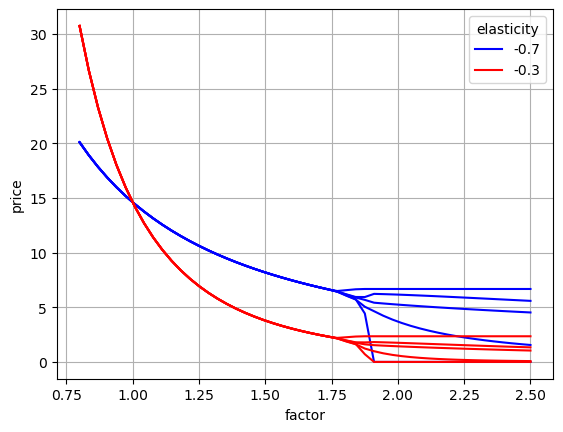

In [8]:
fig, ax = plt.subplots()
colors = dict(zip(elasticities, ['blue', 'red']))
results.set_index('factor').groupby('e').apply(lambda df: df.LMP.apply(pd.Series).plot(ax=ax, color=colors[df.name]))
ax.grid()
ax.set_ylabel('price')
[line.set_label(elasticities[i//5] if line.get_label() == '0' else '_nolegend_') for i, line in enumerate(ax.lines)]
ax.legend(title='elasticity')
fig.show()